# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [184]:
data = pd.read_csv('data/vehicles.csv')

In [185]:
data.head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [186]:
missing_values_per_column = data.isnull().sum()
print("Missing values per column:\n", missing_values_per_column)

# Drop columns with a lot of missing data
for column in data.columns:
    unique_values = data[column].unique()
    print(f"\nUnique values in column '{column}':")
    print(unique_values)

print(f"Total items '{len(data)}'")

Missing values per column:
 id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Unique values in column 'id':
[7222695916 7218891961 7221797935 ... 7301591147 7301591140 7301591129]

Unique values in column 'region':
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 'southeast alaska'
 'flagstaff / sed

In [187]:
###
### Sanitize existing data
###
# Remove duplicate rows, if any
df = pd.DataFrame(data)
df = df.drop_duplicates()

# Convert string columns to lowercase
categorical_cols = ['model', 'region']

for col in categorical_cols:
    df[col] = df[col].str.lower()

# Handle missing odometer data with median
median_odometer = df['odometer'].median()
df['odometer'].fillna(median_odometer, inplace=True)

# Convert NaN values to mode
mode_fuel = df['fuel'].mode()[0]
mode_transmission = df['transmission'].mode()[0]
df['fuel'].fillna(mode_fuel, inplace=True)
df['transmission'].fillna(mode_transmission, inplace=True)

# Convert NaN values to 'unknown'
df['fuel'].fillna("unknown", inplace=True)
df['condition'].fillna("unknown", inplace=True)
df['drive'].fillna("unknown", inplace=True)
df['cylinders'].fillna("unknown", inplace=True)
df['title_status'].fillna("unknown", inplace=True)
df['paint_color'].fillna("unknown", inplace=True)

# Populate manufacturer based on model
df_cleaned_model = df.dropna(subset=['model'])
model_to_manufacturer = df_cleaned_model.dropna(subset=['manufacturer']).set_index('model')['manufacturer'].to_dict()

df_cleaned_model = df_cleaned_model.dropna(subset=['model']).copy()

df_cleaned_model['manufacturer'].fillna(df_cleaned_model['model'].map(model_to_manufacturer), inplace=True)

# Drop still unknown manufacturer values since this is critical
df_cleaned_model = df_cleaned_model.dropna(subset=['manufacturer']).copy()

# Add a new column age
current_date = datetime.datetime.now()
current_year = current_date.year
df_cleaned_model['age'] = current_year - df_cleaned_model['year']

# Drop unneccessary columns, year is covered by age
columns_to_drop = ['year', 'size', 'VIN', 'url', 'region_url', 'image_url', 'id', 'description', 'condition', 'lat', 'long', 'state', 'county']
df_cleaned = df_cleaned_model.drop(columns=columns_to_drop, errors='ignore')

# Remove vehicles over 25 years old, these could include classics that are valuable which would effect overall data
df_cleaned = df_cleaned[df_cleaned['age'] <= 25].copy()
df_cleaned.reset_index(drop=True, inplace=True)

# Remove type of 'bus', we want to focus mostly on passanger vehicles
df_cleaned = df_cleaned[df_cleaned['type'] != 'bus'].copy()
df_cleaned.reset_index(drop=True, inplace=True)

# Remove models with more than two words, likely not a valid model
df_cleaned['word_count'] = df_cleaned['model'].apply(lambda x: len(str(x).split()))
df_cleaned = df_cleaned[df_cleaned['word_count'] <= 2]
df_cleaned.drop(columns=['word_count'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

# Filter to keep only models that appear more than once, the data quality for this column is low
model_counts = df_cleaned['model'].value_counts()
models_to_keep = model_counts[model_counts > 1].index
df_cleaned = df_cleaned[df_cleaned['model'].isin(models_to_keep)].copy()
df_cleaned.reset_index(drop=True, inplace=True)

# Sanitize model data to remove 'custom', can add other keywords here
df_cleaned = df_cleaned[~df_cleaned['model'].isin(['custom'])].copy()
df_cleaned.reset_index(drop=True, inplace=True)

df_cleaned.head(5)


,region,price,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age
0,auburn,22590,chevrolet,silverado 1500,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,15.0
1,auburn,15000,ford,f-150 xlt,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,12.0
2,auburn,35000,toyota,tacoma,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,6.0
3,auburn,0,jeep,compass,unknown,gas,99615.0,clean,automatic,unknown,SUV,unknown,14.0
4,auburn,14000,honda,odyssey,6 cylinders,gas,95000.0,clean,automatic,fwd,mini-van,silver,13.0


Original number of rows: 257065
Number of rows after 'price' filter (>$100k removed): 229560


Text(0, 0.5, 'Price ($)')

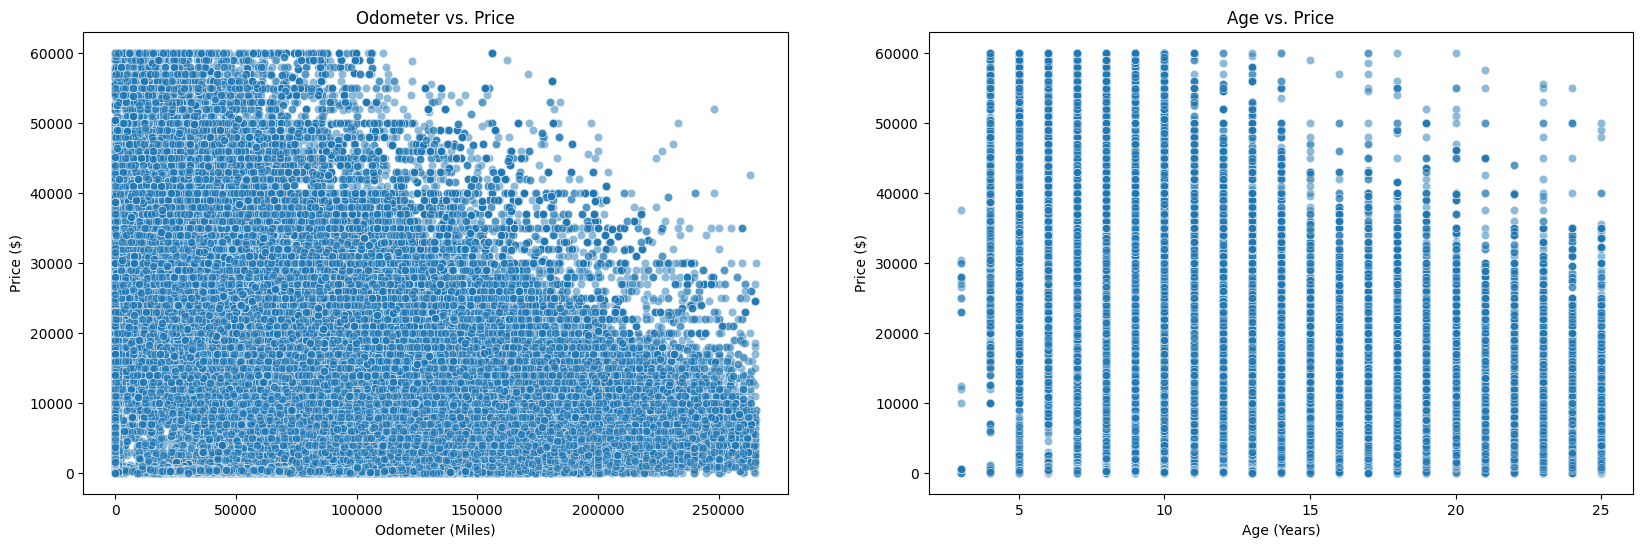

In [188]:
# Filter outliers and plot
outlier_cols = ['odometer']
for col in outlier_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

df_cleaned.reset_index(drop=True, inplace=True)

# Filter price outliers, set a price limit at $60,000 to exclude ultra luxury and exotic vehicles
price_col = 'price'
upper_limit = 60000
lower_limit = 1

print(f"Original number of rows: {len(df_cleaned)}")

df_cleaned = df_cleaned[
    (df_cleaned[price_col] >= lower_limit) & 
    (df_cleaned[price_col] <= upper_limit)
]

df_cleaned.reset_index(drop=True, inplace=True)
print(f"Number of rows after 'price' filter (>$100k removed): {len(df_cleaned)}")

df_cleaned['log_price'] = np.log1p(df_cleaned['price'])
df_cleaned['log_odometer'] = np.log1p(df_cleaned['odometer'])

# Plot the top three columns that potentially effect price
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(x='odometer', y='price', data=df_cleaned, ax=axes[0], alpha=0.5)
axes[0].set_title('Odometer vs. Price')
axes[0].set_xlabel('Odometer (Miles)')
axes[0].set_ylabel('Price ($)')

sns.scatterplot(x='age', y='price', data=df_cleaned, ax=axes[1], alpha=0.5)
axes[1].set_title('Age vs. Price')
axes[1].set_xlabel('Age (Years)')
axes[1].set_ylabel('Price ($)')

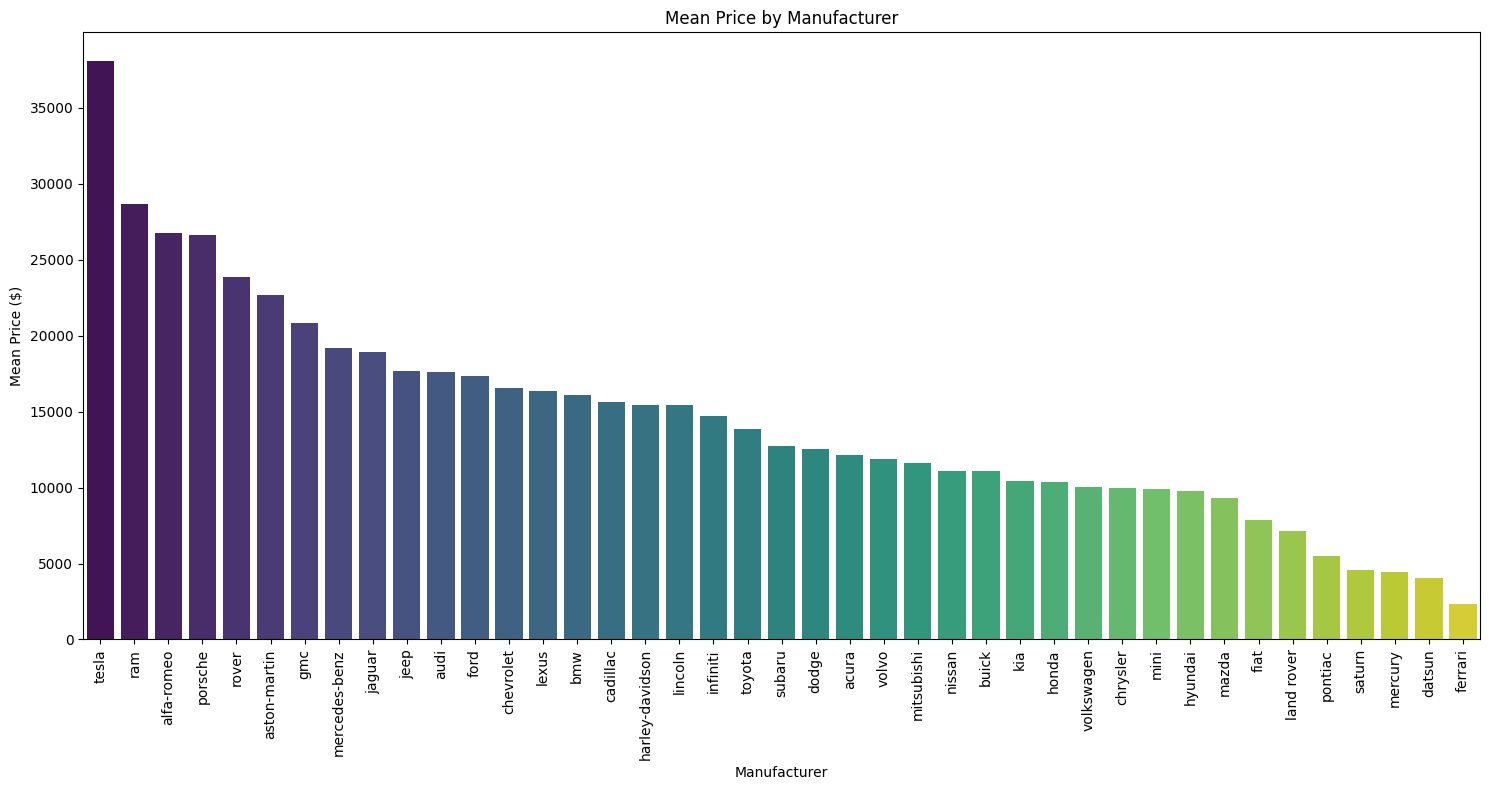

In [189]:
# Plot mean price by manufacturer
mean_price_by_manufacturer = df_cleaned.groupby('manufacturer')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x=mean_price_by_manufacturer.index, y=mean_price_by_manufacturer.values, palette='viridis')
plt.title('Mean Price by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Mean Price ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Axes: >

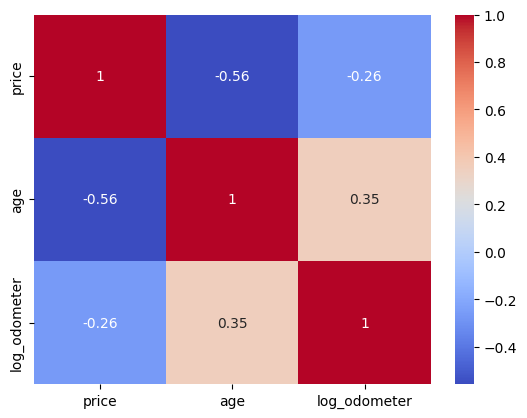

In [190]:
num_features = ['price','age','log_odometer']
sns.heatmap(df_cleaned[num_features].corr(), annot=True, cmap='coolwarm')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [191]:
features = ['age', 'log_odometer', 'model', 'manufacturer', 'drive', 'paint_color', 'fuel', 'type']
target = 'log_price'

df_cleaned.dropna(subset=features, inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

X = df_cleaned[features]
y = df_cleaned[target]

# Split & train the data
split_ratio = 0.8
n_samples = len(X)
indices = np.random.permutation(n_samples)
split_index = int(split_ratio * n_samples)
train_indices, test_indices = indices[:split_index], indices[split_index:]
X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

# Use ColumnTransformer since there are a large number of models and manufacturers
numerical_features = ['age', 'log_odometer']
categorical_features = ['model', 'manufacturer', 'drive', 'paint_color', 'fuel', 'type']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out(features)

print("Training data processing complete")
print(f"Shape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed testing data: {X_test_processed.shape}")


Training data processing complete
Shape of processed training data: (137832, 3681)
Shape of processed testing data: (34459, 3681)


In [193]:
svd = TruncatedSVD(n_components=3)
X_train_svd = svd.fit_transform(X_train_processed)
X_test_svd = svd.transform(X_test_processed)
print("TruncatedSVD complete on train & test data.")


TruncatedSVD complete on train & test data.


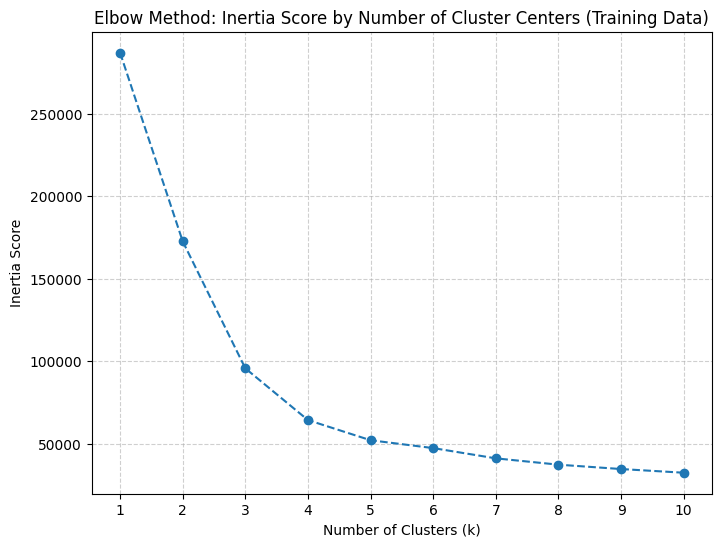

/var/folders/d_/n7pnw4jd51913q2g8vvzfctw0000gr/T/ipykernel_14793/817609331.py:77: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([h for h, l in unique_labels], [l for h, l in unique_labels], title='Cluster / Dataset')


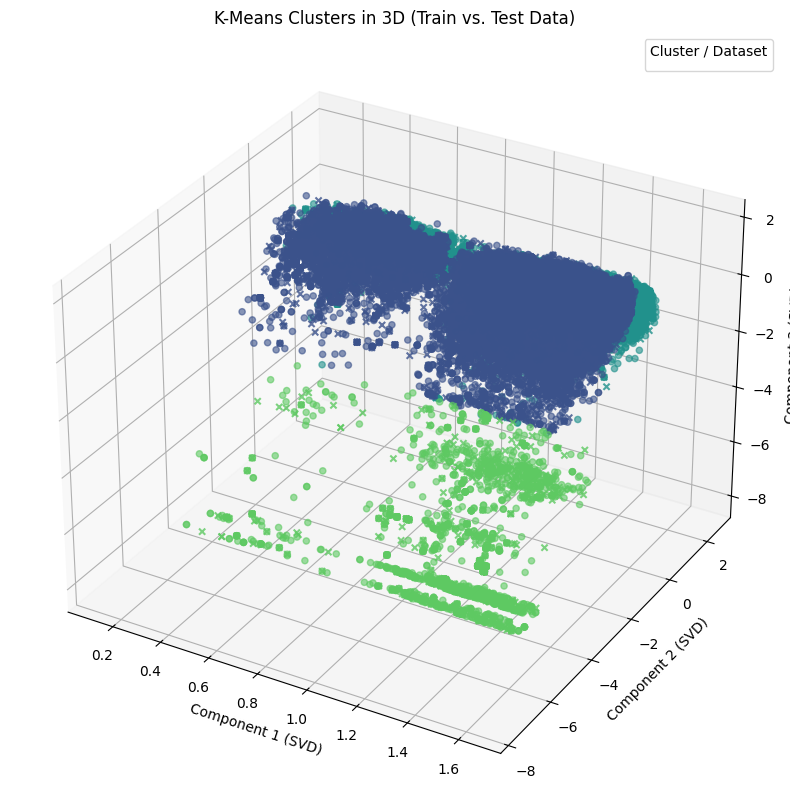

KMeans Clustering complete.
Training cluster sizes:
 0    79824
1    56375
2     1633
Name: count, dtype: int64
Testing cluster sizes:
 0    19794
1    14245
2      420
Name: count, dtype: int64


In [194]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_train_clusters = kmeans.fit_predict(X_train_svd)
# Predict clusters for the test data using the model fitted on the train data
kmeans_test_clusters = kmeans.predict(X_test_svd)

inertias = []
max_clusters = 10 
# Calculate inertia for different numbers of clusters on the training data
for i in range(1, max_clusters + 1):
    kmeans_elbow = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(X_train_svd)
    inertias.append(kmeans_elbow.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(list(range(1, max_clusters + 1)), inertias, '--o')
plt.xticks(list(range(1, max_clusters + 1)))
plt.title('Elbow Method: Inertia Score by Number of Cluster Centers (Training Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Combine 3D SVD data and clusters for plotting
train_df = pd.DataFrame(X_train_svd, columns=['C1', 'C2', 'C3'])
train_df['Cluster'] = kmeans_train_clusters
train_df['Dataset'] = 'Train'

test_df = pd.DataFrame(X_test_svd, columns=['C1', 'C2', 'C3'])
test_df['Cluster'] = kmeans_test_clusters
test_df['Dataset'] = 'Test'

# Visualize the data
plot_df_3d = pd.concat([train_df, test_df])
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

palette = sns.color_palette('viridis', n_colors=len(plot_df_3d['Cluster'].unique()))
cluster_color_map = {cluster: palette[cluster] for cluster in plot_df_3d['Cluster'].unique()}

# Plotting the points
for cluster in plot_df_3d['Cluster'].unique():
    subset = plot_df_3d[plot_df_3d['Cluster'] == cluster]
    
    # Plot training points
    train_subset = subset[subset['Dataset'] == 'Train']
    ax.scatter(
        train_subset['C1'],
        train_subset['C2'],
        train_subset['C3'],
        c=[cluster_color_map[cluster]],
        marker='o',
        label=f'Cluster {cluster} (Train)',
        alpha=0.6
    )

    # Plot testing points (x-axis)
    test_subset = subset[subset['Dataset'] == 'Test']
    ax.scatter(
        test_subset['C1'],
        test_subset['C2'],
        test_subset['C3'],
        c=[cluster_color_map[cluster]],
        marker='x',
        label=f'Cluster {cluster} (Test)',
        alpha=0.8
    )

ax.set_xlabel('Component 1 (SVD)')
ax.set_ylabel('Component 2 (SVD)')
ax.set_zlabel('Component 3 (SVD)')
plt.title('K-Means Clusters in 3D (Train vs. Test Data)')

# Simplify the legend
handles, labels = ax.get_legend_handles_labels()
from itertools import groupby
unique_labels = list(dict(zip(labels, handles)).items())
ax.legend([h for h, l in unique_labels], [l for h, l in unique_labels], title='Cluster / Dataset')
plt.show()

print("KMeans Clustering complete.")
print("Training cluster sizes:\n", pd.Series(kmeans_train_clusters).value_counts())
print("Testing cluster sizes:\n", pd.Series(kmeans_test_clusters).value_counts())


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Linear Regression results
Mean Absolute Error (Log Price): 0.4650
Mean Absolute Error (Actual Price): $4,867.67
----------------------------------------


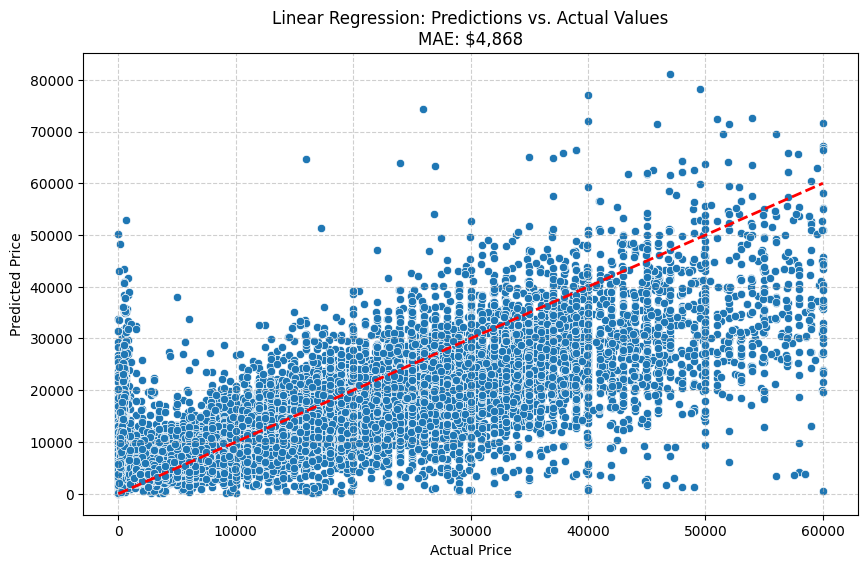

In [195]:
# Linear regression model prediction
linear_model = LinearRegression()

linear_model.fit(X_train_processed, y_train)

y_pred_log = linear_model.predict(X_test_processed)

# Mean absolute error
mae_log = mean_absolute_error(y_test, y_pred_log)

# Convert to dollar amount
y_test_abs = np.expm1(y_test)
y_pred_abs = np.expm1(y_pred_log)
mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)

print("Linear Regression results")
print(f"Mean Absolute Error (Log Price): {mae_log:.4f}")
print(f"Mean Absolute Error (Actual Price): ${mae_abs:,.2f}")
print("-" * 40)

# Create a visualization of the predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_abs, y=y_pred_abs)
plt.plot([y_test_abs.min(), y_test_abs.max()], [y_test_abs.min(), y_test_abs.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Linear Regression: Predictions vs. Actual Values\nMAE: ${mae_abs:,.0f}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Mean Absolute Error (Log Price): 0.4654
Mean Absolute Error (Actual Price): $4,885.99
----------------------------------------


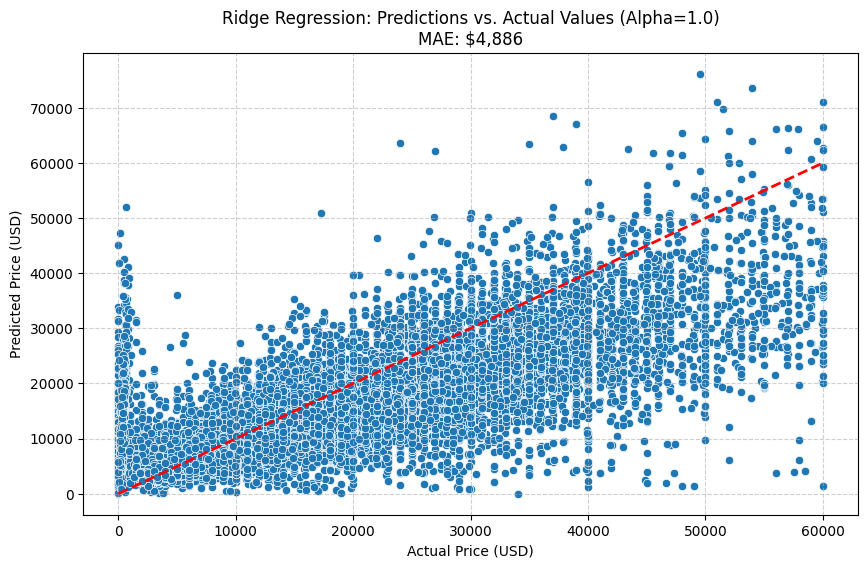

In [196]:
# Ridge Regression Model
ridge_model = Ridge(alpha=1.0) 

ridge_model.fit(X_train_processed, y_train)

y_pred_log = ridge_model.predict(X_test_processed)
mae_log = mean_absolute_error(y_test, y_pred_log)

# Convert to dollar amounts
y_test_abs = np.expm1(y_test)
y_pred_abs = np.expm1(y_pred_log)
mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)

print(f"Mean Absolute Error (Log Price): {mae_log:.4f}")
print(f"Mean Absolute Error (Actual Price): ${mae_abs:,.2f}")
print("-" * 40)

# Create a visualization of the predictions vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_abs, y=y_pred_abs)
plt.plot([y_test_abs.min(), y_test_abs.max()], [y_test_abs.min(), y_test_abs.max()], 'r--', lw=2)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title(f"Ridge Regression: Predictions vs. Actual Values (Alpha=1.0)\nMAE: ${mae_abs:,.0f}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [197]:
results = {}
def evaluate_model(model, name, X_train_p, y_train, X_test_p, y_test, feature_names):
    model.fit(X_train_p, y_train)
    y_pred_log = model.predict(X_test_p)
    
    # Calculate MAE
    y_test_abs = np.expm1(y_test)
    y_pred_abs = np.expm1(y_pred_log)
    mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)
    
    # Coefficient Analysis
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    })
    
    positive_impact_features = coefficients_df[coefficients_df['Coefficient'] > 0]
    positive_impact_features = positive_impact_features.sort_values(by='Coefficient', ascending=False)
    
    return mae_abs, positive_impact_features.head(10)

# Linear regression
linear_mae, linear_coeffs = evaluate_model(
    LinearRegression(), 
    "Linear Regression", 
    X_train_processed, 
    y_train, 
    X_test_processed, 
    y_test, 
    feature_names
)
results['Linear Regression'] = {'MAE': linear_mae, 'Coefficients': linear_coeffs}

# Lasso
lasso_mae, lasso_coeffs = evaluate_model(
    Lasso(alpha=0.001, max_iter=5000), 
    "Lasso Regression", 
    X_train_processed, 
    y_train, 
    X_test_processed, 
    y_test, 
    feature_names
)
results['Lasso Regression'] = {'MAE': lasso_mae, 'Coefficients': lasso_coeffs}

print(f"Linear Regression MAE (Actual Price): ${results['Linear Regression']['MAE']:,.2f}")
print(f"Lasso Regression MAE (Actual Price): ${results['Lasso Regression']['MAE']:,.2f}")

print("Lasso -top features that increase price")
print(results['Lasso Regression']['Coefficients'].to_markdown(index=False))

print("Linear Regression - top features that increase price")
print(results['Linear Regression']['Coefficients'].to_markdown(index=False))

Linear Regression MAE (Actual Price): $4,867.67
Lasso Regression MAE (Actual Price): $5,579.56
Lasso -top features that increase price
| Feature                     |   Coefficient |
|:----------------------------|--------------:|
| cat__model_corvette         |      0.881523 |
| cat__type_pickup            |      0.486413 |
| cat__fuel_diesel            |      0.451552 |
| cat__manufacturer_porsche   |      0.385268 |
| cat__type_convertible       |      0.335751 |
| cat__manufacturer_lexus     |      0.326169 |
| cat__type_truck             |      0.280409 |
| cat__model_wrangler         |      0.238625 |
| cat__model_silverado 2500hd |      0.148386 |
| cat__model_suburban         |      0.14025  |
Linear Regression - top features that increase price
| Feature                      |   Coefficient |
|:-----------------------------|--------------:|
| cat__model_g500 g-wagon      |       2.38387 |
| cat__model_viper             |       2.31493 |
| cat__model_g-class g500      |       2

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.